In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [14]:
df = pd.read_csv('data3.csv')

In [15]:
df.head()

,MARSTAT,EDUCATION,NUMHH,INCOME,FACE
0,1,16,3,43000,20000
1,1,9,3,12000,130000
2,1,16,5,120000,1500000
3,1,17,4,40000,50000
4,1,15,2,25000,0


In [16]:
df = df[df['FACE'] >= 50000]
df.head()

,MARSTAT,EDUCATION,NUMHH,INCOME,FACE
1,1,9,3,12000,130000
2,1,16,5,120000,1500000
3,1,17,4,40000,50000
5,2,11,4,28000,220000
7,1,16,3,100000,600000


In [25]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(method = 'box-cox', standardize = False)
FACE = np.asarray(df['FACE'])
FACE = FACE.reshape(-1,1)
pt.fit(FACE)
FACE = pt.transform(FACE)
df['FACEbc'] = FACE

In [26]:
df.head()

,MARSTAT,EDUCATION,NUMHH,INCOME,FACE,FACEbc
1,1,9,3,12000,130000,4.489410
2,1,16,5,120000,1500000,4.667959
3,1,17,4,40000,50000,4.391879
5,2,11,4,28000,220000,4.535591
7,1,16,3,100000,600000,4.611143


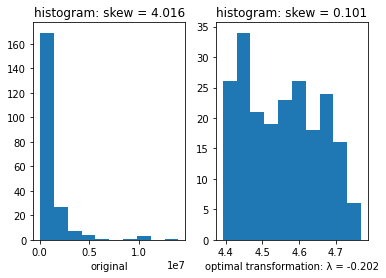

In [27]:
skew1 = round(df['FACE'].skew(),3)
skew2 = round(df['FACEbc'].skew(),3)
lambdas = pt.lambdas_[0]

f, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(df['FACE'])
ax1.set_title('histogram: skew = %s' % skew1)
ax1.set_xlabel('original')

ax2.hist(df['FACEbc'])
ax2.set_title('histogram: skew = %s' % skew2)
ax2.set_xlabel('optimal transformation: %s = %s' % (chr(0x03BB), round(lambdas,3)))

#plot
plt.show()

In [28]:
df_dc = pd.get_dummies(df, columns=['MARSTAT'])
df_dc['logINCOME'] = np.log(df_dc['INCOME'])

In [31]:
from sklearn.linear_model import LinearRegression
X = df_dc[['EDUCATION', 'NUMHH', 'logINCOME', 'MARSTAT_0', 'MARSTAT_2']]
y = df_dc['FACEbc']

reg = LinearRegression().fit(X,y)
B = reg.coef_
B = np.insert(B, 0, reg.intercept_, axis = 0)
print(B)

SE = np.std(y, ddof=1)
print(SE)

y_pred = reg.predict(X)
from sklearn.metrics import r2_score
R2 = r2_score(y, y_pred)
print(R2)

[ 4.054996    0.01335962  0.00759392  0.02511296 -0.04642982 -0.01841342]
0.10323297449402534
0.33359974845365026


In [97]:
df = pd.read_csv('data4.csv')

In [98]:
def calc_gradient2(B, y, x):
    #depends on the dimmension of B
    
    B0 = B[0,0] 
    B1 = B[0,1]
    
    f0 = -2*np.exp(B0+B1*x)*(y-np.exp(B0+B1*x)) # dR/dB_0 
    f1 = -2*np.exp(B1*x+B0)*x*(y-np.exp(B0+B1*x)) # dR/dB_1
    
    return np.array([np.sum(f0), np.sum(f1)])



def calc_gradient1(B, y, x):
    #depends on the dimmension of B
    
    B = B.reshape(1,-1)

    B0 = B[0,0] 
    B1 = B[0,1]
    B2 = B[0,2]
    B3 = B[0,3]
    
    f0 = -2*np.sin(B1*x-B2)*(y-B0*np.sin(B1*x-B2)-x*B3) # dR/dB_0
    f1 = -2*B0*x*np.cos(B1*x-B2)*(y-B0*np.sin(B1*x-B2)-x*B3) # dR/dB_1
    f2 = 2*(y-B0*np.sin(B1*x-B2)-x*B3)*B0*np.cos(-B2+B1*x) # dR/dB_1
    f3 = -2*x*(y-B0*np.sin(B1*x-B2)-x*B3)# dR/dB_1
    
    return np.array([np.sum(f0), np.sum(f1), np.sum(f2), np.sum(f3)])



def calc_Jacobian(B, y, x):
    #depends on the dimmension of B
    
    B0 = B[0,0]
    B1 = B[0,1]
    
    df0b0 = -2* (np.exp(B0+B1*x)*y - 2*np.exp(2*B1*x+2*B0)) # df0 / dB_0
    df0b1 = -2* (np.exp(B0+B1*x)*x*y - 2*np.exp(2*B1*x+2*B0)*x) # df0 / dB_1
    df1b0 = -2*x* (np.exp(B1*x+B0)*y - 2*np.exp(2*B1*x+2*B0)) # df1 / dB_0
    df1b1 = -2*x* (np.exp(B1*x+B0)*x*y - 2*np.exp(2*B1*x+2*B0)*x) # df1 / dB_1
    
    return np.array([
            [np.sum(df0b0), np.sum(df0b1)], 
            [np.sum(df1b0), np.sum(df1b1)]
            ])

#Gradient Descent
"""
Loss Function = R(B) = SUM{ R_i(B) } = SUM{ (y_i - yhat_i(B))^2 }

B(r+1) = B(r) - eta * Grad( Loss Function )
B(r+1) = B(r) - eta * SUM{ Grad{ (y_i - yhat_i(B))^2  }}

"""


def gradient_descent(x, y, B, learning_rate, max_iter):
    
    loss_history = []
    iteration = 0
    B_history = [B]
    
    for i in range(max_iter):
        B = B.reshape(1,-1)
    
        B0 = B[0,0] 
        B1 = B[0,1]
        B2 = B[0,2]
        B3 = B[0,3]

        y_hat = B0*np.sin(B1*x-B2)+B3*x  # depends on the model function
        loss = np.sum((y-y_hat)**2)
        
        #stop if there are no improvements in the loss
        if iteration > 0:
            if np.abs(loss - loss_history[0]) == 0:
                iteration = iteration - 1
                break
                
        #keep track of the loss for each iteration)
        loss_history.insert(0,loss)
        
        gradient = calc_gradient1(B,y,x)
        
        diff = learning_rate * gradient

        B = B-diff
        B_history.append(B)
        
        iteration = iteration + 1
        
    return loss, learning_rate, B, iteration, loss_history

#Newton Raphson
"""
Loss Function = R(B) = SUM{ R_i(B) } = SUM{ (y_i - yhat_i(B))^2 }

B(r+1) = B(r) - Jac( Loss Function )^-1 * Grad( Loss Function )
B(r+1) = B(r) - Jac( (y_i - yhat_i(B))^2 )^-1 *  Grad( (y_i - yhat_i(B))^2 )

"""


def newton_raphson(x, y, B, max_iter):
    
    loss_history = []
    iteration = 0
    B_history = [B]

        
    for i in range(max_iter):        
        y_hat = np.exp(B[0,0] + B[0,1]*x)
        loss = np.sum((y - y_hat)**2)
                            
        #stop if there are no improvements in the loss
        if iteration > 0:
            if np.abs(loss - loss_history[0]) == 0:
                iteration = iteration - 1
                break   
        
        #keep track of the loss for each iteration
        loss_history.insert(0,loss)
                
        gradient = calc_gradient(B,y,x)
        Jacobian = calc_Jacobian(B,y,x)
        diff = np.matmul(np.linalg.inv(Jacobian),gradient)
        
        B = B - diff
        B_history.append(B)

        iteration = iteration + 1       
        
        
                
    return loss, B, iteration, loss_history, B_history

In [99]:
x = df['x']
y = df['y']
B = np.array([0.1,0.1,0.1,0.1])

In [100]:
result = gradient_descent(x,y,B,0.00007,10000)